<img src="https://github.com/sobester/ADRpy/raw/master/docs/ADRpy/ADRpy_splash.png" width="40%" align="left">

*Weight is an important aspect of sizing an aircraft concept, and is primarily driven by the structural loads demanded of the airframe in service. Key components of an airframe must be relied upon to safely withstand these loads to ensure safe operation throughout the component lifetime.*

*Airworthiness directives provided by National Aviation Authorities, are regulatory measures that an aircraft should be expected to meet in both the design and serviceable life of an aircraft. These generally relate to the physical condition of individual aircraft, which must not compromise the safety of persons on-board or those that maintain the aircraft when the structure is placed under duress.*

*In this notebook we look at how airworthiness relates to the* **flight envelope** *of the aircraft.*

# Airworthiness of an Aircraft with ADRpy - The Flight Envelope

Flight envelopes are a useful medium with which to communicate the capabilities of an aircraft at a variety of airspeeds. The velocity-load factor (V-n) diagram is a way of depicting the maximum load factor an aircraft can endure during a symmetrical loading deliberate manoeuvre, or a sudden vertical gust resulting in similar loading to an aircraft in level-flight.

#### Design V-speeds Definitions

_$V_A$ (Manoeuvre Speed)_ :

This is the speed at which a full deflection of the aircraft's control surfaces, will reach the manoeuvre limit load. Above this, a full deflection of the control surfaces exceeds the manoeuvre limit load, and may exceed the positive limit load of the aircraft's structure, damaging it.

_$V_B$ (Maximum Gust Intensity Speed)_ :

This is the speed at which a gust of the maximum intensity as defined by specifications, will cause the aircraft to exceed the stall load condition. It is up to the manufacturer whether or not they list this V speed. Maximum gust intensity is the product of a representative gust of 66 feet per second for commuter aircraft, and 50 feet per second for other categories.

_$V_C$ (Cruise Speed)_ :

A designer will select this speed through an optimisation process, and for most commercial aircraft, this is the speed for which the aircraft has been designed to perform most optimally at - since the aircraft will spend most of its flight time here.

_$V_D$ (Dive Speed)_ :

This is the design speed which the aircraft must not exceed during a dive. Above this speed, excessive vibration or buffeting is likely to cause damage to the aircraft, or loss of control authority.

_$V_S$ (Stall Speed, W = MTOW)_ :

The computed stall speed, flaps retracted at the maximum take-off design weight.

_$V_{S1}$ (Stall Speed, W $\leq$ MTOW)_ :

The computed stall speed, flaps retracted at a particular design weight.

## Anatomy of the V-n Diagram

While reducing aircraft weight is a key aspect of improving performance and economy, sacrificing structural integrity for this goal without fully understanding the service loads an aircraft may encounter could prove even costlier. For this reason, National Aviation Authorities (NAAs) provide directives on the minimum positive and negative g-loads an aircraft should be able to withstand in both manoeuvre and gust loading cases.

#### Limit Manoeuvre Envelope

The limit manoeuvre envelope describes the load factor induced by deflection of the control surfaces by a given amount, in a deliberate action by the pilot. Along stall curves the surfaces are considered to be at maximum deflection, and therefore can not undergo greater loading at a lower airspeed. The upper limit on airspeed is given by the design dive speed $V_D$.

Beyond the manoeuvre speed $V_A$, the stall-curve load factor exceeds the designed limit load of the structure. To prevent accidental overstressing of the airframe, the control surface actuators should be limited by the pilot or flight management system. Guidance on appropriate minimum positive and maximum negative limit load factors is provided by NAAs in documents outlining the requirements for aircraft safety certification.

#### Limit Gust Envelope

The gust envelope describes the load factors experienced by an aircraft in level-flight should it encounter a representative gust, empirically derived from historical weather data. The magnitude of the most intense representative gust is dependent on the altitude of flight phase, as well as the aircraft type. Commuter aircraft require validation against stronger gust loading.

#### Limit Combined Envelope

The European Union Aviation Safety Agency (EASA) Certification Specification 23 (CS-23) Amendment 4 is the model document used for airworthiness certification, and is the document from which the `airworthiness` module draws its regulatory requirements. Below is the contained exemplary combination of the limit manoeuvre and gust envelopes.

<img src="https://github.com/sobester/ADRpy/raw/master/docs/ADRpy/img/cs23_333d.png" width="100%" align="left">

## Example - Gudmundsson's Hypothetical Aircraft

In _General Aviation Aircraft Design: Applied Methods and Procedures_ by S. Gudmundsson, the author describes a hypothetical aircraft which may be used to stress-test a designer's capacity to produce more complex V-n loading diagrams. The diagram is constructed with guidance from the EASA CS-23 Amdt. 4.

First we import the necessary modules, and set up dictionary variables defining the hypothetical aircraft's key design parameters. 

In [1]:
# Make sure we have a copy of ADRpy!
from ADRpy import airworthiness as aw
from ADRpy import unitconversions as co

In [2]:
# 'maxlevelspeed_ktas' is not currently implemented or parsed in any way, and may be ignored
gudmundsson_brief = {'cruisealt_m': 0, 'cruisespeed_ktas': 107, 'maxlevelspeed_ktas': 140}

gudmundsson_def = {'aspectratio': (38 ** 2) / 130, 'wingarea_m2': co.feet22m2(130),
                   'weight_n': co.lbf2n(1320), 'weightfractions': {'cruise': 1}}

gudmundsson_perf = {'CLmaxclean': 1.396, 'CLminclean': -1, 'CLslope': 6.23}

Secondly, specify the desired dive speed $V_D$. Should dive speed not be specified or be considered inappropriate by the regulatory material, $V_D$ defaults to the minimum possible value as defined by CS-23.

In [3]:
divespeed_keas = 150

Finally, we create an object of the `CertificationSpecifications` class.

In [4]:
concept = aw.CertificationSpecifications(gudmundsson_brief, gudmundsson_def, gudmundsson_perf)

We can now plot the flight envelope for this aircraft using the 'normal' aircraft category identifier `'norm'`, and the MTOW wing-loading. Calling the `flightenvelope` method is the simplest way to do this, and returns a dictionary of coordinates for all the labelled points.

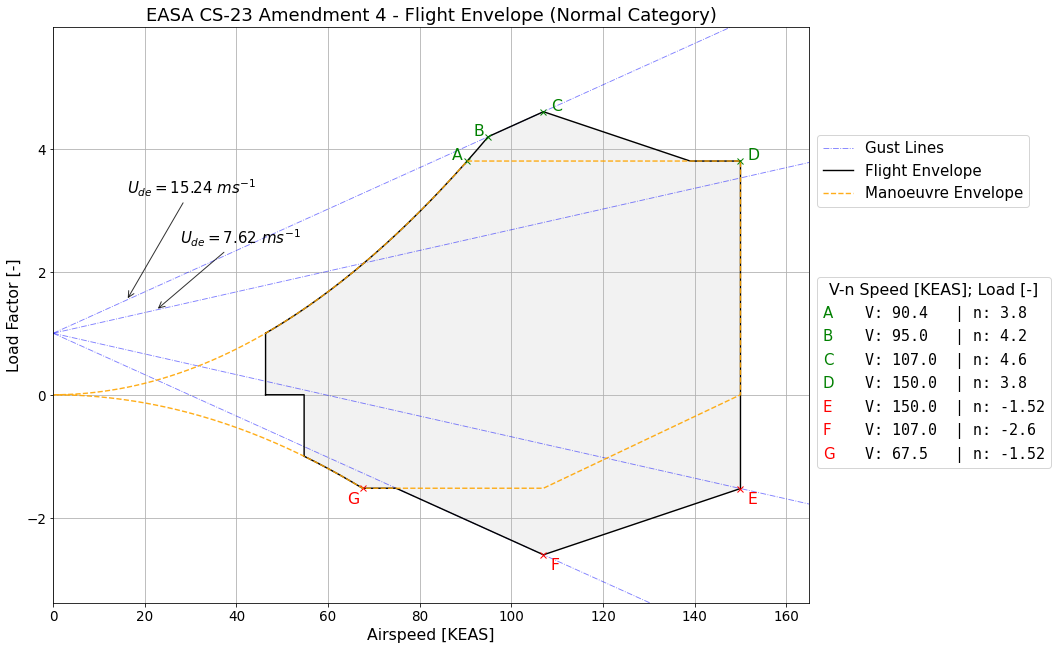

{'A': (90.35471752385638, 3.8),
 'B': (94.95299271121138, 4.196614992600004),
 'C': (106.99999424475222, 4.602180636123947),
 'D': (150, 3.8),
 'E': (150, -1.5248931050530978),
 'F': (106.99999424475222, -2.602180636123947),
 'G': (67.51861690060592, -1.52)}

In [5]:
wingload_pa = concept.acobj.weight_n / concept.acobj.wingarea_m2

concept.flightenvelope(wingloading_pa=wingload_pa, category='norm', vd_keas=divespeed_keas, textsize=15, figsize_in=[15, 10], show=True)